# Introduction to GeoPandas

This quick tutorial introduces the key concepts and basic features of GeoPandas to help you get started with your projects.

## Concepts

GeoPandas, as the name suggests, extends the popular data science library [pandas](https://pandas.pydata.org) by adding support for geospatial data. If you are not familiar with `pandas`, we recommend taking a quick look at its [Getting started documentation](https://pandas.pydata.org/docs/getting_started/index.html#getting-started) before proceeding.

The core data structure in GeoPandas is the `geopandas.GeoDataFrame`, a subclass of `pandas.DataFrame`, that can store geometry columns and perform spatial operations. The `geopandas.GeoSeries`, a subclass of `pandas.Series`, handles the geometries. Therefore, your `GeoDataFrame` is a combination of `pandas.Series`, with traditional data (numerical, boolean, text etc.), and `geopandas.GeoSeries`, with geometries (points, polygons etc.). You can have as many columns with geometries as you wish; unlike in some typical desktop GIS software.

![geodataframe schema](https://geopandas.org/en/stable/_images/dataframe.svg)

Each `GeoSeries` can contain any geometry type (you can even mix them within a single array) and has a `GeoSeries.crs` attribute, which stores information about the projection (CRS stands for Coordinate Reference System). Therefore, each `GeoSeries` in a `GeoDataFrame` can be in a different projection, allowing you to have, for example, multiple versions (different projections) of the same geometry.

Only one `GeoSeries` in a `GeoDataFrame` is considered the _active geometry column_, which means that all geometric operations applied to a `GeoDataFrame` operate on this column.
The active geometry column is accessed via the `GeoDataFrame.geometry` attribute.


<div class="alert alert-info">
User guide
    
See more on [data structures](../docs/user_guide/data_structures.rst) in the user guide.
</div>


Let's see how some of these concepts work in practice.

## Reading and writing files

First, we need to read some data.

### Reading files

Assuming you have a file containing both data and geometry (e.g. GeoPackage, GeoJSON, Shapefile), you can read it using `geopandas.read_file()`, which automatically detects the filetype and creates a `GeoDataFrame`. This tutorial uses the `"nybb"` dataset, a map of New York boroughs, which is available through the `geodatasets` package. Therefore, we use `geodatasets.get_path()` to download the dataset and retrieve the path to the local copy.

In [ ]:
!pip install geopandas geodatasets

import geopandas
from geodatasets import get_path

path_to_data = get_path("nybb")
gdf = geopandas.read_file(path_to_data)

gdf

Output hidden; open in https://colab.research.google.com to view.

### Writing files

To write a `GeoDataFrame` back to file use `GeoDataFrame.to_file()`. By default, the file format is inferred by the file extension (e.g. `.shp` for Shapefile, `.geojson` for GeoJSON), but you can specify this explicitly with the `driver` keyword.

In [ ]:
gdf.to_file("my_file.geojson", driver="GeoJSON")

<div class="alert alert-info">
User guide
    
See more on [reading and writing files](../docs/user_guide/io.rst) in the user guide.
</div>



## Simple accessors and methods

Now we have our `GeoDataFrame` and can start working with its geometry.

Since there was only one geometry column in the New York Boroughs dataset, this column automatically becomes the _active_ geometry and spatial methods used on the `GeoDataFrame` will be applied to the `"geometry"` column.

### Measuring area

To measure the area of each polygon (or MultiPolygon in this specific case), access the `GeoDataFrame.area` attribute, which returns a `pandas.Series`. Note that `GeoDataFrame.area` is just `GeoSeries.area` applied to the _active_ geometry column.

But first, to make the results easier to read, set the names of the boroughs as the index:

In [ ]:
gdf = gdf.set_index("BoroName")

In [ ]:
gdf["area"] = gdf.area
gdf["area"]

BoroName
Staten Island    1.623822e+09
Queens           3.045214e+09
Brooklyn         1.937478e+09
Manhattan        6.364712e+08
Bronx            1.186926e+09
Name: area, dtype: float64

### Getting polygon boundary and centroid

To get the boundary of each polygon (LineString), access the `GeoDataFrame.boundary`:

In [ ]:
gdf["boundary"] = gdf.boundary
gdf["boundary"]

BoroName
Staten Island    MULTILINESTRING ((970217.022 145643.332, 97022...
Queens           MULTILINESTRING ((1029606.077 156073.814, 1029...
Brooklyn         MULTILINESTRING ((1021176.479 151374.797, 1021...
Manhattan        MULTILINESTRING ((981219.056 188655.316, 98094...
Bronx            MULTILINESTRING ((1012821.806 229228.265, 1012...
Name: boundary, dtype: geometry

Since we have saved boundary as a new column, we now have two geometry columns in the same `GeoDataFrame`.

We can also create new geometries, which could be, for example, a buffered version of the original one (i.e., `GeoDataFrame.buffer(10)`) or its centroid:

In [ ]:
gdf["centroid"] = gdf.centroid
gdf["centroid"]

BoroName
Staten Island      POINT (941639.45 150931.991)
Queens           POINT (1034578.078 197116.604)
Brooklyn          POINT (998769.115 174169.761)
Manhattan         POINT (993336.965 222451.437)
Bronx              POINT (1021174.79 249937.98)
Name: centroid, dtype: geometry

### Measuring distance

We can also measure how far each centroid is from the first centroid location.

In [ ]:
first_point = gdf["centroid"].iloc[0]
gdf["distance"] = gdf["centroid"].distance(first_point)
gdf["distance"]

BoroName
Staten Island         0.000000
Queens           103781.535276
Brooklyn          61674.893421
Manhattan         88247.742789
Bronx            126996.283623
Name: distance, dtype: float64

Note that `geopandas.GeoDataFrame` is a subclass of `pandas.DataFrame`, so we have all the pandas functionality available to use on the geospatial dataset â€” we can even perform data manipulations with the attributes and geometry information together.

For example, to calculate the average of the distances measured above, access the 'distance' column and call the mean() method on it:

In [ ]:
gdf["distance"].mean()

76140.09102166798

## Making maps

GeoPandas can also plot maps, so we can check how the geometries appear in space. To plot the active geometry, call `GeoDataFrame.plot()`. To color code by another column, pass in that column as the first argument. In the example below, we plot the active geometry column and color code by the `"area"` column. We also want to show a legend (`legend=True`).

<Axes: >

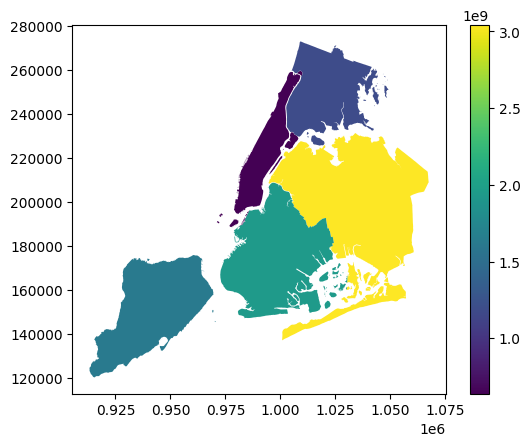

In [ ]:
gdf.plot("area", legend=True)

You can also explore your data interactively using `GeoDataFrame.explore()`, which behaves in the same way `plot()` does but returns an interactive map instead.

In [ ]:
!pip install mapclassify

gdf.explore("area", legend=False)

Output hidden; open in https://colab.research.google.com to view.

Switching the active geometry (`GeoDataFrame.set_geometry`) to centroids, we can plot the same data using point geometry.

<Axes: >

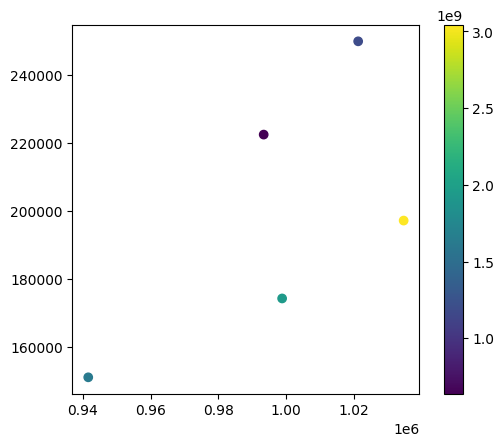

In [ ]:
gdf = gdf.set_geometry("centroid")
gdf.plot("area", legend=True)

And we can also layer both `GeoSeries` on top of each other. We just need to use one plot as an axis for the other.

<Axes: >

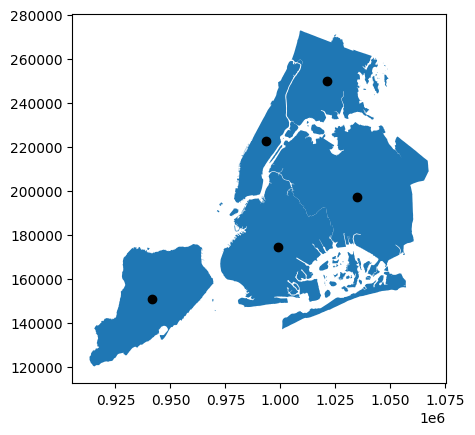

In [ ]:
ax = gdf["geometry"].plot()
gdf["centroid"].plot(ax=ax, color="black")

Now we set the active geometry back to the original `GeoSeries`.

In [ ]:
gdf = gdf.set_geometry("geometry")

<div class="alert alert-info">
User guide
    
See more on [mapping](../docs/user_guide/mapping.rst) in the user guide.
</div>

## Geometry creation

We can further work with the geometry and create new shapes based on those we already have.

### Convex hull

If we are interested in the convex hull of our polygons, we can access `GeoDataFrame.convex_hull`.

In [ ]:
gdf["convex_hull"] = gdf.convex_hull

<Axes: >

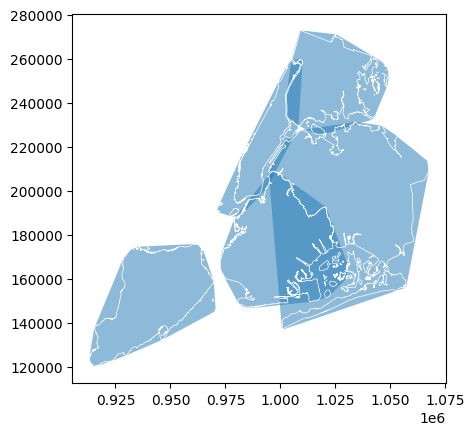

In [ ]:
# saving the first plot as an axis and setting alpha (transparency) to 0.5
ax = gdf["convex_hull"].plot(alpha=0.5)
# passing the first plot and setting linewidth to 0.5
gdf["boundary"].plot(ax=ax, color="white", linewidth=0.5)

### Buffer

In other cases, we may need to buffer the geometry using `GeoDataFrame.buffer()`. Geometry methods are automatically applied to the active geometry, but we can apply them directly to any `GeoSeries` as well. Let's buffer the boroughs and their centroids and plot both on top of each other.

In [ ]:
# buffering the active geometry by 10 000 feet (geometry is already in feet)
gdf["buffered"] = gdf.buffer(10000)

# buffering the centroid geometry by 10 000 feet (geometry is already in feet)
gdf["buffered_centroid"] = gdf["centroid"].buffer(10000)

<Axes: >

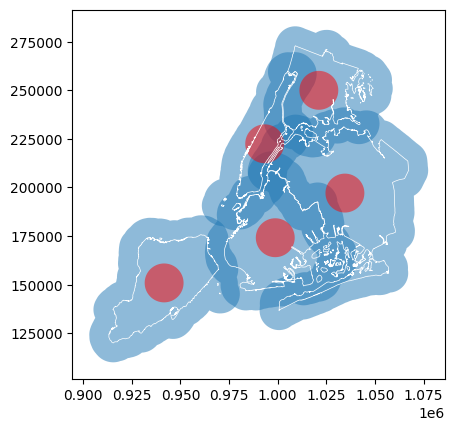

In [ ]:
# saving the first plot as an axis and setting alpha (transparency) to 0.5
ax = gdf["buffered"].plot(alpha=0.5)
# passing the first plot as an axis to the second
gdf["buffered_centroid"].plot(ax=ax, color="red", alpha=0.5)
# passing the first plot and setting linewidth to 0.5
gdf["boundary"].plot(ax=ax, color="white", linewidth=0.5)

<div class="alert alert-info">
User guide
    
See more on [geometry manipulations](../docs/user_guide/geometric_manipulations.rst) in the user guide.
</div>

## Geometry relations

We can also ask about the spatial relations of different geometries. Using the geometries above, we can check which of the buffered boroughs intersect the original geometry of Brooklyn, i.e., is within 10 000 feet from Brooklyn.

First, we get a polygon of Brooklyn.

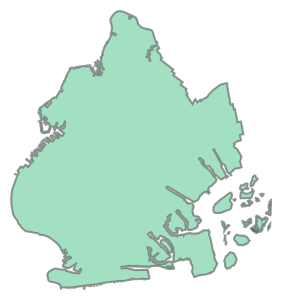

In [ ]:
brooklyn = gdf.loc["Brooklyn", "geometry"]
brooklyn

The polygon is a [shapely geometry object](https://shapely.readthedocs.io/en/stable/manual.html#geometric-objects), as any other geometry used in GeoPandas.

In [ ]:
type(brooklyn)

shapely.geometry.multipolygon.MultiPolygon

Then we can check which of the geometries in `gdf["buffered"]` intersects it.

In [ ]:
gdf["buffered"].intersects(brooklyn)

BoroName
Staten Island     True
Queens            True
Brooklyn          True
Manhattan         True
Bronx            False
dtype: bool

Only Bronx (on the north) is more than 10 000 feet away from Brooklyn. All the others are closer and intersect our polygon.

Alternatively, we can check which buffered centroids are entirely within the original boroughs polygons. In this case, both `GeoSeries` are aligned, and the check is performed for each row.

In [ ]:
gdf["within"] = gdf["buffered_centroid"].within(gdf)
gdf["within"]

BoroName
Staten Island     True
Queens            True
Brooklyn         False
Manhattan        False
Bronx            False
Name: within, dtype: bool

We can plot the results on the map to confirm the finding.

<Axes: >

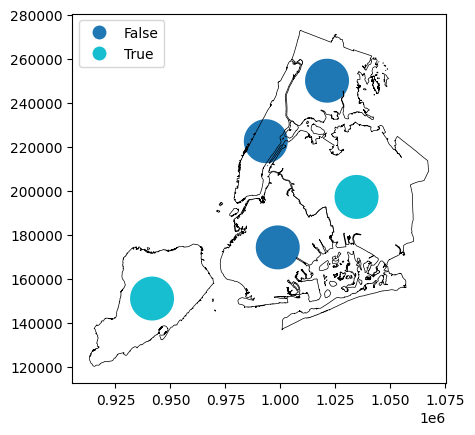

In [ ]:
gdf = gdf.set_geometry("buffered_centroid")
# using categorical plot and setting the position of the legend
ax = gdf.plot(
    "within", legend=True, categorical=True, legend_kwds={"loc": "upper left"}
)
# passing the first plot and setting linewidth to 0.5
gdf["boundary"].plot(ax=ax, color="black", linewidth=0.5)

## Projections

Each `GeoSeries` has its Coordinate Reference System (CRS) accessible at `GeoSeries.crs`. The CRS tells GeoPandas where the coordinates of the geometries are located on the earth's surface. In some cases, the CRS is geographic, which means that the coordinates are in latitude and longitude. In those cases, its CRS is WGS84, with the authority code `EPSG:4326`. Let's see the projection of our NY boroughs `GeoDataFrame`.

In [ ]:
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US survey foot)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Geometries are in `EPSG:2263` with coordinates in feet. We can easily re-project a `GeoSeries` to another CRS, like `EPSG:4326` using `GeoSeries.to_crs()`.

<Axes: >

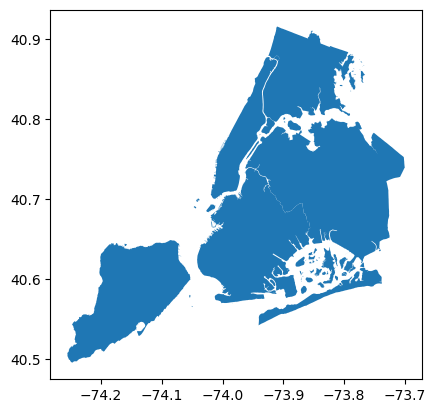

In [ ]:
gdf = gdf.set_geometry("geometry")
boroughs_4326 = gdf.to_crs("EPSG:4326")
boroughs_4326.plot()

In [ ]:
boroughs_4326.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Notice the difference in coordinates along the axes of the plot. Where we had 120 000 - 280 000 (feet) before, we now have 40.5 - 40.9 (degrees). In this case, `boroughs_4326` has a `"geometry"` column in WGS84 but all the other (with centroids etc.) remain in the original CRS.

<div class="alert alert-warning">
Warning
    
For operations that rely on distance or area, you always need to use a projected CRS (in meters, feet, kilometers etc.) not a geographic one (in degrees). GeoPandas operations are planar, whereas degrees reflect the position on a sphere. Therefore, spatial operations using degrees may not yield correct results. For example, the result of `gdf.area.sum()` (projected CRS) is 8 429 911 572 ft<sup>2</sup> but the result of `boroughs_4326.area.sum()` (geographic CRS) is 0.083.
</div>

<div class="alert alert-info">
User guide
    
See more on [projections](../docs/user_guide/projections.rst) in the user guide.
</div>

## What next?

With GeoPandas we can do much more than what has been introduced so far, from [aggregations](../docs/user_guide/aggregation_with_dissolve.rst), to [spatial joins](../docs/user_guide/mergingdata.rst), to [geocoding](../docs/user_guide/geocoding.rst), and [much more](../gallery/index.rst).

Head over to the [user guide](../docs/user_guide.rst) to learn more about the different features of GeoPandas, the [Examples](../gallery/index.rst) to see how they can be used, or to the [API reference](../docs/reference.rst) for the details.